### Frame extraction

In [5]:
import cv2

def extract_frames(video_path, image_output_folder):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_filename = f"{image_output_folder}/frame_{frame_count:04d}.jpg"
        cv2.imwrite(frame_filename, frame)
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames to {image_output_folder}")

if __name__== "__main__":
    video_path= "/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/right/AVI15.AVI"
    #"/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/left/AVI57.avi"
    image_output_folder= "/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/right/avi_15"
    extract_frames(video_path, image_output_folder)

Extracted 1600 frames to /Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/right/avi_15


#### Visualizing few images.

In [7]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt


In [8]:
CHECKERBOARD = (7, 9)  # Adjust to your checkerboard
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


In [9]:
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)


In [10]:
def find_corners(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
    
    if ret:
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        return corners2, img
    return corners, img

In [11]:
left_images = sorted(glob.glob('/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/left/avi_57/images_to_calib/*.jpg'))
right_images = sorted(glob.glob('/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/right/avi_15/images_to_calib/*.jpg'))


In [12]:
right_images

['/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/right/avi_15/images_to_calib/frame_0000.jpg',
 '/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/right/avi_15/images_to_calib/frame_0001.jpg',
 '/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/right/avi_15/images_to_calib/frame_0002.jpg',
 '/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/right/avi_15/images_to_calib/frame_0003.jpg',
 '/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/right/avi_15/images_to_calib/frame_0004.jpg',
 '/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/right/avi_15/images_to_calib/frame_0267.jpg',
 '/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/right/avi_15/images_to_calib/frame_0268.jpg',
 '/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/right/avi_15/images_to_calib/frame_0269.jpg',
 '/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calib

In [14]:
# Find corners in both cameras
left_corners, left_img = find_corners(left_images[6])  # Use first image
right_corners, right_img = find_corners(right_images[6])


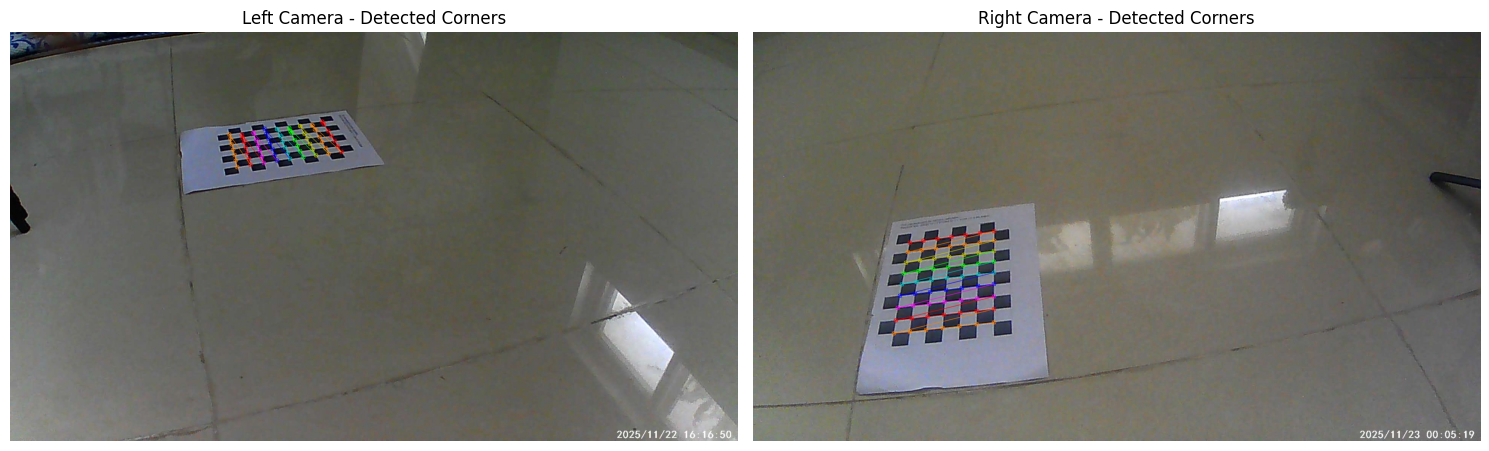

In [15]:
left_img_with_corners = left_img.copy()
right_img_with_corners = right_img.copy()

# Draw the corners
cv2.drawChessboardCorners(left_img_with_corners, CHECKERBOARD, left_corners, True)
cv2.drawChessboardCorners(right_img_with_corners, CHECKERBOARD, right_corners, True)

# Display side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].imshow(cv2.cvtColor(left_img_with_corners, cv2.COLOR_BGR2RGB))
axes[0].set_title('Left Camera - Detected Corners')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(right_img_with_corners, cv2.COLOR_BGR2RGB))
axes[1].set_title('Right Camera - Detected Corners')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [16]:

# Step 3: Compute homography if corners detected
if left_corners is not None and right_corners is not None:
    # Reshape corners for homography
    left_pts = left_corners.reshape(-1, 2)
    right_pts = right_corners.reshape(-1, 2)
    
    # Compute homography matrix
    H, mask = cv2.findHomography(left_pts, right_pts, cv2.RANSAC, 5.0)
    
    print("Homography Matrix:")
    print(H)
    
    # Step 4: Warp left image to right camera's perspective
    h, w = right_img.shape[:2]
    warped = cv2.warpPerspective(left_img, H, (w, h))
    cv2.imwrite("wrapped_lefft_to_right.png", warped)
    
    # Visualize result
    # cv2.imshow("Original Left", left_img)
    # cv2.imshow("Original Right", right_img)
    # cv2.imshow("Warped Left to Right", warped)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
else:
    print("Could not detect checkerboard in one or both images")

Homography Matrix:
[[ 3.55334856e+00  1.29247136e+01 -4.18758022e+03]
 [-1.80495670e+00  2.28201617e+00  3.35651472e+03]
 [ 3.11744597e-03  3.24169927e-03  1.00000000e+00]]


### Saving the homography matrix

In [17]:
import numpy as np

np.save("homo_left_to_right.npy", H)

### Validation

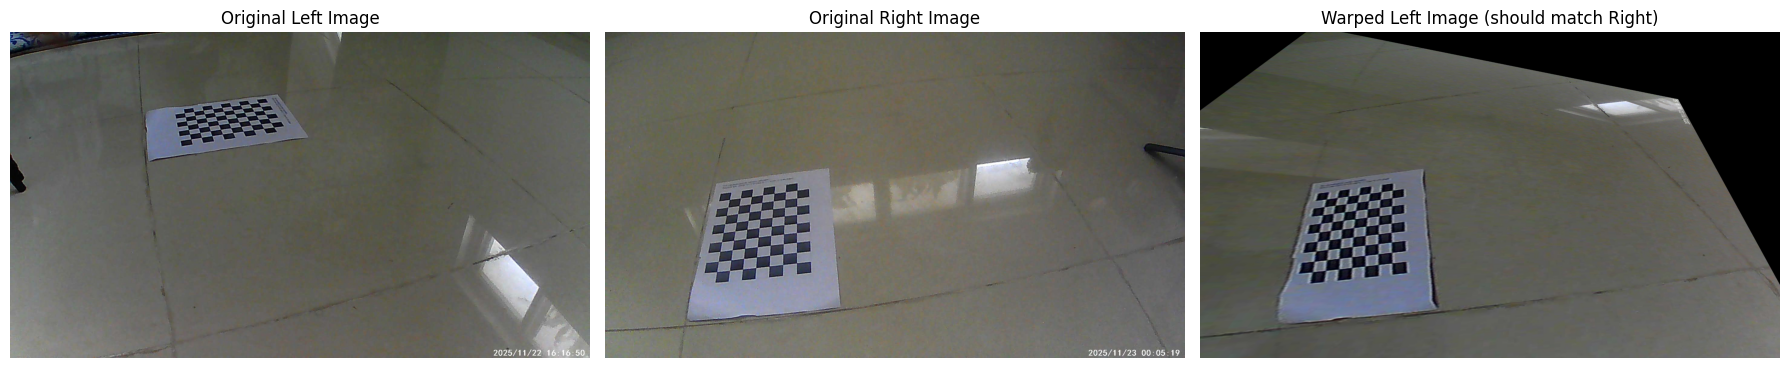

In [18]:
# Method 1: Visual comparison - Warp and overlay
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Left Image')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
axes[1].set_title('Original Right Image')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
axes[2].set_title('Warped Left Image (should match Right)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

Mean reprojection error: 5.30 pixels
Max reprojection error: 22.77 pixels
Std deviation: 7.13 pixels


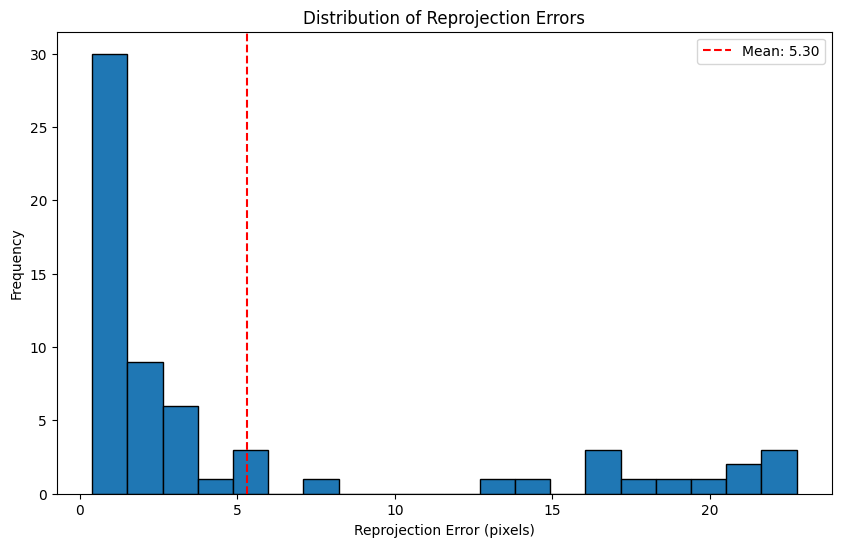

In [19]:
# Method 3: Transform left corners using H and compare with right corners
transformed_left_pts = cv2.perspectiveTransform(left_pts.reshape(-1, 1, 2), H)
transformed_left_pts = transformed_left_pts.reshape(-1, 2)

# Calculate reprojection error
errors = np.linalg.norm(transformed_left_pts - right_pts, axis=1)
mean_error = np.mean(errors)
max_error = np.max(errors)

print(f"Mean reprojection error: {mean_error:.2f} pixels")
print(f"Max reprojection error: {max_error:.2f} pixels")
print(f"Std deviation: {np.std(errors):.2f} pixels")

# Visualize errors
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, edgecolor='black')
plt.xlabel('Reprojection Error (pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Reprojection Errors')
plt.axvline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:.2f}')
plt.legend()
plt.show()

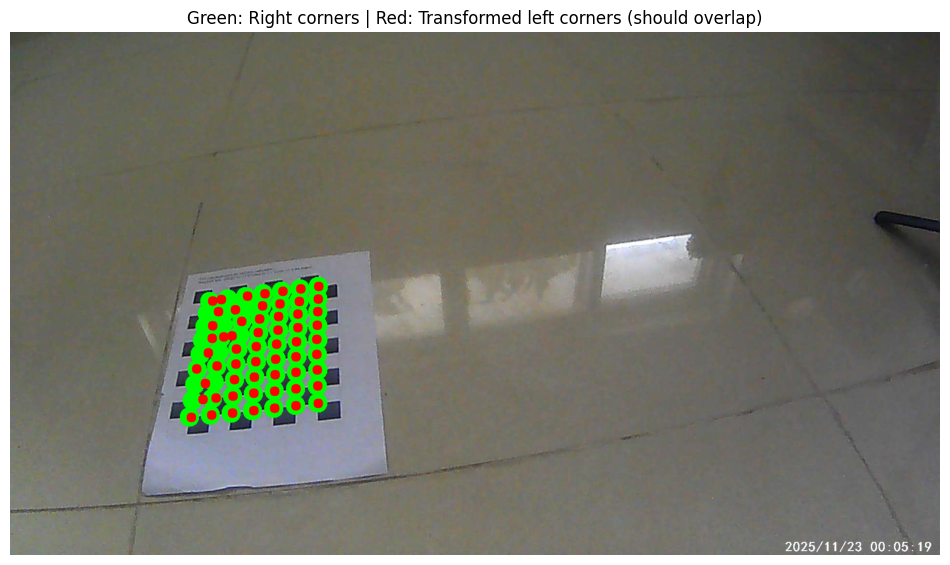

In [20]:
# Method 4: Draw transformed corners on right image
right_img_validation = right_img.copy()

# Draw original right corners in green
for pt in right_pts:
    cv2.circle(right_img_validation, tuple(pt.astype(int)), 20, (0, 255, 0), -1)

# Draw transformed left corners in red
for pt in transformed_left_pts:
    cv2.circle(right_img_validation, tuple(pt.astype(int)), 10, (0, 0, 255), -1)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(right_img_validation, cv2.COLOR_BGR2RGB))
plt.title('Green: Right corners | Red: Transformed left corners (should overlap)')
plt.axis('off')
plt.show()

Processing checkerboard images...
✓ Image pair 0: 63 points added
✓ Image pair 1: 63 points added
✓ Image pair 2: 63 points added
✓ Image pair 3: 63 points added
✓ Image pair 4: 63 points added
✓ Image pair 5: 63 points added
✓ Image pair 6: 63 points added
✓ Image pair 7: 63 points added
✓ Image pair 8: 63 points added
✓ Image pair 9: 63 points added
✓ Image pair 10: 63 points added
✓ Image pair 11: 63 points added
✓ Image pair 12: 63 points added
✓ Image pair 13: 63 points added
✓ Image pair 14: 63 points added
✓ Image pair 15: 63 points added
✗ Image pair 16: Checkerboard not detected in both images
✓ Image pair 17: 63 points added
✗ Image pair 18: Checkerboard not detected in both images
✓ Image pair 19: 63 points added
✓ Image pair 20: 63 points added
✓ Image pair 21: 63 points added
✓ Image pair 22: 63 points added
✓ Image pair 23: 63 points added
✓ Image pair 24: 63 points added
✓ Image pair 25: 63 points added
✓ Image pair 26: 63 points added
✓ Image pair 27: 63 points added
✓ 

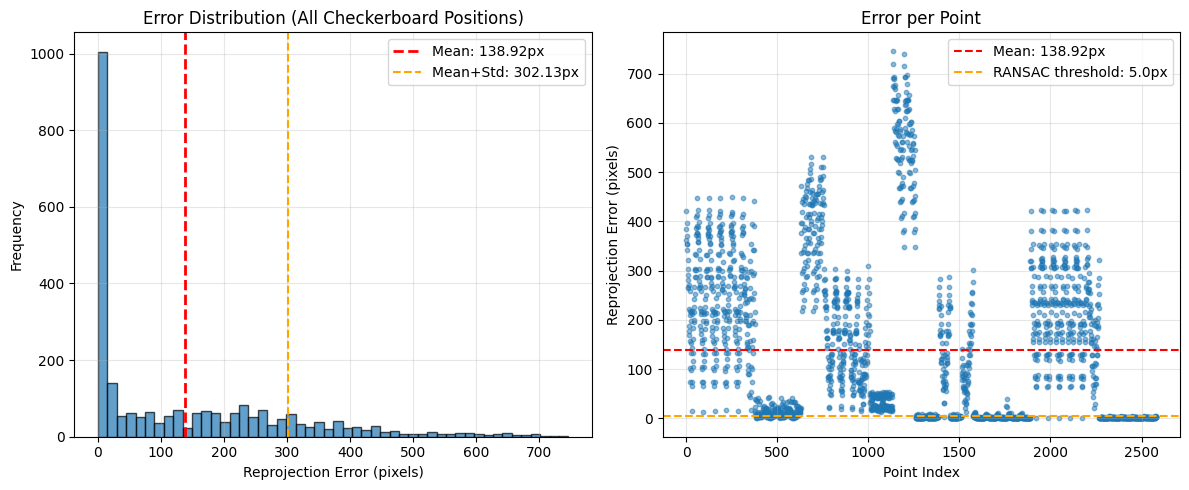


✓ Saved improved homography as 'homo_left_to_right_multipos.npy'


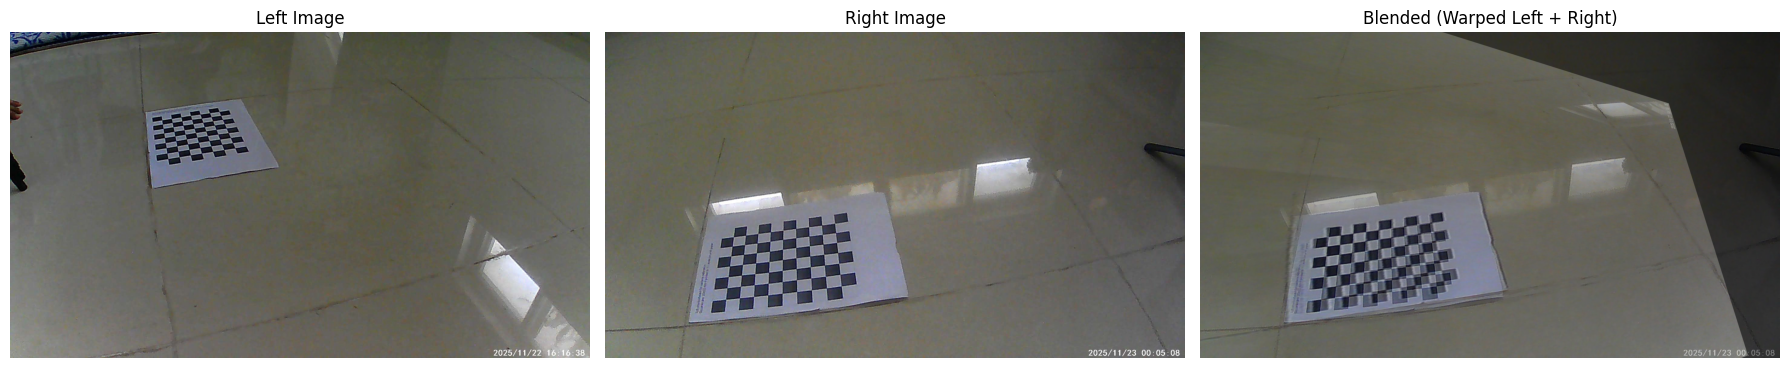

In [36]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

CHECKERBOARD = (7, 9)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

def find_corners(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
    
    if ret:
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        return corners2, img, ret
    return None, img, ret

# Load ALL images (not just one)
left_images = sorted(glob.glob('/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/left/avi_57/images_to_calib/*.jpg'))[0:]
right_images = sorted(glob.glob('/Users/akashmanna/ws/opervu/unobstructed_view_gen/cemera_calibration/right/avi_15/images_to_calib/*.jpg'))[0:]

# Collect points from MULTIPLE checkerboard positions
all_left_pts = []
all_right_pts = []
successful_pairs = []

print("Processing checkerboard images...")
for i, (left_path, right_path) in enumerate(zip(left_images, right_images)):
    left_corners, left_img, ret_left = find_corners(left_path)
    right_corners, right_img, ret_right = find_corners(right_path)
    
    if ret_left and ret_right:
        # Add all corner points from this image pair
        left_pts = left_corners.reshape(-1, 2)
        right_pts = right_corners.reshape(-1, 2)
        
        all_left_pts.extend(left_pts)
        all_right_pts.extend(right_pts)
        successful_pairs.append(i)
        print(f"✓ Image pair {i}: {len(left_pts)} points added")
    else:
        print(f"✗ Image pair {i}: Checkerboard not detected in both images")

print(f"\nTotal points collected: {len(all_left_pts)}")
print(f"From {len(successful_pairs)} image pairs")

# Convert to numpy arrays
all_left_pts = np.array(all_left_pts, dtype=np.float32)
all_right_pts = np.array(all_right_pts, dtype=np.float32)

# Compute homography from ALL collected points
if len(all_left_pts) >= 4:
    H, mask = cv2.findHomography(all_left_pts, all_right_pts, cv2.RANSAC, 5.0)
    
    print("\n=== Homography Matrix (Multi-Position) ===")
    print(H)
    
    
    # Calculate reprojection error
    transformed_pts = cv2.perspectiveTransform(all_left_pts.reshape(-1, 1, 2), H)
    transformed_pts = transformed_pts.reshape(-1, 2)
    
    errors = np.linalg.norm(transformed_pts - all_right_pts, axis=1)
    mean_error = np.mean(errors)
    max_error = np.max(errors)
    std_error = np.std(errors)
    
    print(f"\n=== Reprojection Error (All Positions) ===")
    print(f"Mean error: {mean_error:.2f} pixels")
    print(f"Max error: {max_error:.2f} pixels")
    print(f"Std deviation: {std_error:.2f} pixels")
    print(f"Inliers: {np.sum(mask)}/{len(mask)} ({100*np.sum(mask)/len(mask):.1f}%)")
    
    # Visualize error distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(mean_error, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_error:.2f}px')
    plt.axvline(mean_error + std_error, color='orange', linestyle='--', label=f'Mean+Std: {mean_error+std_error:.2f}px')
    plt.xlabel('Reprojection Error (pixels)')
    plt.ylabel('Frequency')
    plt.title('Error Distribution (All Checkerboard Positions)')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.scatter(range(len(errors)), errors, alpha=0.5, s=10)
    plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:.2f}px')
    plt.axhline(5.0, color='orange', linestyle='--', label='RANSAC threshold: 5.0px')
    plt.xlabel('Point Index')
    plt.ylabel('Reprojection Error (pixels)')
    plt.title('Error per Point')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save the improved homography
    np.save("homo_left_to_right_multipos.npy", H)
    print("\n✓ Saved improved homography as 'homo_left_to_right_multipos.npy'")
    
    # Test on a sample image pair
    test_idx = successful_pairs[0] if successful_pairs else 0
    left_test_img = cv2.imread(left_images[test_idx])
    right_test_img = cv2.imread(right_images[test_idx])
    
    h, w = right_test_img.shape[:2]
    warped_test = cv2.warpPerspective(left_test_img, H, (w, h))
    
    # Blend to visualize alignment
    blended = cv2.addWeighted(warped_test, 0.5, right_test_img, 0.5, 0)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(cv2.cvtColor(left_test_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Left Image')
    axes[0].axis('off')
    
    axes[1].imshow(cv2.cvtColor(right_test_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Right Image')
    axes[1].axis('off')
    
    axes[2].imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Blended (Warped Left + Right)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Not enough points to compute homography!")